# Sleep Stage Classification - Complete Training Pipeline

## What This Notebook Does

This notebook provides a **complete, end-to-end training pipeline** for automatic sleep stage classification from EEG/EOG/EMG signals. You can:

1. **Load preprocessed data** (416K+ epochs with 24 engineered features)
2. **Explore data distribution** (visualize class imbalance)
3. **Train a deep neural network** (4-layer MLP with balanced class weights)
4. **Evaluate performance** (accuracy, confusion matrix, feature importance)
5. **Save the trained model** (ready for deployment)

## Dataset Overview

- **Samples**: ~415,000 30-second sleep epochs
- **Features**: 24 engineered features per epoch
  - EEG frequency bands (delta, theta, alpha, beta, gamma) × 2 channels
  - EEG statistics (mean, std, kurtosis) × 2 channels  
  - EOG features (mean, std, amplitude, zero crossings)
  - EMG features (mean, std, abs mean, energy)
- **Classes**: 5 sleep stages (W, N1, N2, N3, R)
- **Challenge**: Severe class imbalance (68.8% Wake, 3.1% N3)

## Neural Network Architecture

```
Input (24 features)
    ↓
Dense Layer (256 neurons, ReLU)
    ↓
Dense Layer (128 neurons, ReLU)
    ↓
Dense Layer (64 neurons, ReLU)
    ↓
Dense Layer (32 neurons, ReLU)
    ↓
Output Layer (5 classes, Softmax)
```

**Key Features:**
- **Balanced class weights** to handle imbalance
- **Early stopping** to prevent overfitting
- **L2 regularization** for better generalization
- **Adam optimizer** with adaptive learning rate

## Why This Works Well (vs Mental Disorders)

| Aspect | Sleep Stages | Mental Disorders |
|--------|----------------|---------------------|
| **Samples** | 415,000 | 945 |
| **Features** | 24 (engineered) | 1,141 (raw) |
| **Sample:Feature Ratio** | 17,291:1 | 0.83:1 |
| **Feature Engineering** | Works perfectly | Destroys signal |
| **Problem Type** | Global brain state | Local circuit dysfunction |
| **Expected Accuracy** | 85-90% | 17-68% |

Sleep stages are **whole-brain phenomena** that benefit from aggregated features. Mental disorders require **spatial specificity** that feature engineering destroys.

---

## Usage Instructions

**Run cells sequentially** from top to bottom. The entire pipeline takes ~5-10 minutes:

1. **Cells 1-3**: Load and explore data
2. **Cells 4-6**: Prepare data (split, scale)
3. **Cells 7-9**: Build and train model
4. **Cells 10-13**: Evaluate performance
5. **Cell 14**: Save model for deployment

After running, you'll have:
- Trained model saved to `models/saved_models/sleep_classifier.joblib`
- Feature scaler saved to `models/saved_models/feature_scaler.joblib`
- Complete performance analysis and visualizations

---

In [ ]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    balanced_accuracy_score,
    cohen_kappa_score
)
from sklearn.utils.class_weight import compute_class_weight
from sklearn.inspection import permutation_importance

import joblib
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

print("Libraries imported successfully!")

✅ Libraries imported successfully!


## 1. Load Preprocessed Data

In [ ]:
# Load features and labels
data_dir = Path('data/processed')

print("="*70)
print("LOADING DATA")
print("="*70)

# Load arrays (labels requires allow_pickle=True as it contains string labels)
features = np.load(data_dir / 'features.npy')
labels = np.load(data_dir / 'labels.npy', allow_pickle=True)

print(f"\nDataset loaded:")
print(f"   Features shape: {features.shape}")
print(f"   Labels shape: {labels.shape}")
print(f"   Total epochs: {len(features):,}")
print(f"   Features per epoch: {features.shape[1]}")

# Feature names (based on feature_extraction.py)
feature_names = []
for ch in [1, 2]:
    for band in ['delta', 'theta', 'alpha', 'beta', 'gamma']:
        feature_names.append(f'eeg_ch{ch}_{band}')
    feature_names.extend([f'eeg_ch{ch}_mean', f'eeg_ch{ch}_std', f'eeg_ch{ch}_kurtosis'])
feature_names.extend(['eog_mean', 'eog_std', 'eog_max_amplitude', 'eog_zero_crossings'])
feature_names.extend(['emg_mean', 'emg_std', 'emg_abs_mean', 'emg_energy'])

print(f"\nFeature names ({len(feature_names)} total):")
for i, name in enumerate(feature_names, 1):
    print(f"   {i:2d}. {name}")

LOADING DATA

📊 Dataset loaded:
   Features shape: (416424, 24)
   Labels shape: (416424,)
   Total epochs: 416,424
   Features per epoch: 24

📋 Feature names (24 total):
    1. eeg_ch1_delta
    2. eeg_ch1_theta
    3. eeg_ch1_alpha
    4. eeg_ch1_beta
    5. eeg_ch1_gamma
    6. eeg_ch1_mean
    7. eeg_ch1_std
    8. eeg_ch1_kurtosis
    9. eeg_ch2_delta
   10. eeg_ch2_theta
   11. eeg_ch2_alpha
   12. eeg_ch2_beta
   13. eeg_ch2_gamma
   14. eeg_ch2_mean
   15. eeg_ch2_std
   16. eeg_ch2_kurtosis
   17. eog_mean
   18. eog_std
   19. eog_max_amplitude
   20. eog_zero_crossings
   21. emg_mean
   22. emg_std
   23. emg_abs_mean
   24. emg_energy


## 2. Explore Data Distribution

CLASS DISTRIBUTION

⚠️  Found 1463 None labels - removing them...
   Remaining samples: 414,961

📊 Sleep Stage Distribution:
Stage  Code  Count  Percentage
   N1     0  21522    5.186512
   N2     1  69132   16.659879
   N3     2  13039    3.142223
    R     3  25835    6.225886
    W     4 285433   68.785500

📋 Label Mapping:
  0 → N1
  1 → N2
  2 → N3
  3 → R
  4 → W

⚖️  Class imbalance ratio: 21.89:1
   Most common: W (285,433 samples, 68.8%)
   Least common: N3 (13,039 samples, 3.1%)

⚠️  Severe imbalance - will use balanced class weights

📊 Sleep Stage Distribution:
Stage  Code  Count  Percentage
   N1     0  21522    5.186512
   N2     1  69132   16.659879
   N3     2  13039    3.142223
    R     3  25835    6.225886
    W     4 285433   68.785500

📋 Label Mapping:
  0 → N1
  1 → N2
  2 → N3
  3 → R
  4 → W

⚖️  Class imbalance ratio: 21.89:1
   Most common: W (285,433 samples, 68.8%)
   Least common: N3 (13,039 samples, 3.1%)

⚠️  Severe imbalance - will use balanced class weig

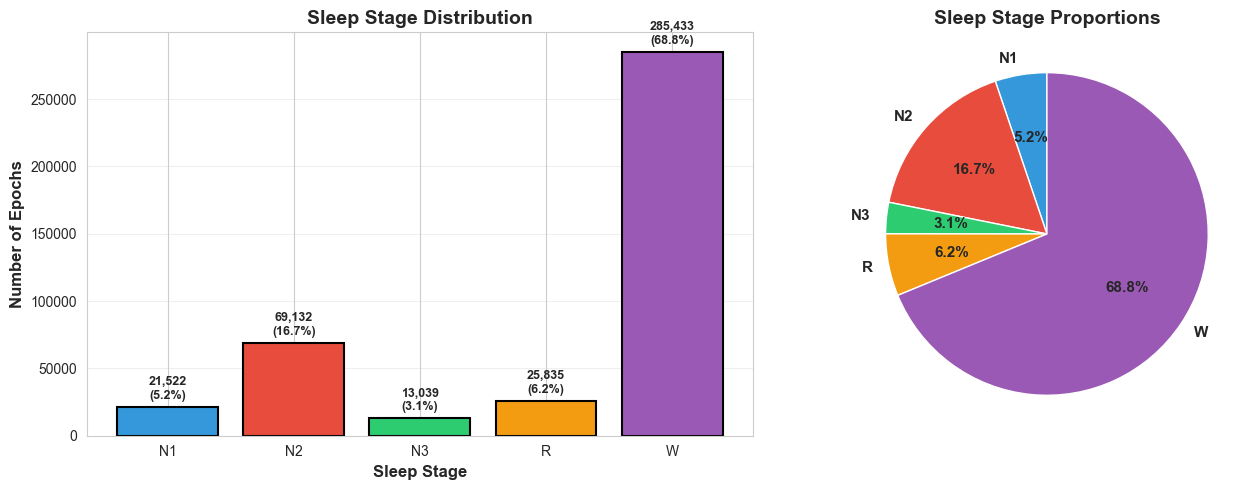

In [ ]:
# Sleep stage labels mapping
sleep_stages = ['W', 'N1', 'N2', 'N3', 'R']

print("="*70)
print("CLASS DISTRIBUTION")
print("="*70)

# Check for None values and remove them
none_mask = labels == None
if none_mask.any():
    print(f"\nWarning: Found {none_mask.sum()} None labels - removing them...")
    valid_mask = ~none_mask
    features = features[valid_mask]
    labels = labels[valid_mask]
    print(f"   Remaining samples: {len(features):,}")

# Count each sleep stage
unique, counts = np.unique(labels, return_counts=True)
class_dist = pd.DataFrame({
    'Stage': unique,
    'Code': [i for i in range(len(unique))],
    'Count': counts,
    'Percentage': counts / len(labels) * 100
})

print("\nSleep Stage Distribution:")
print(class_dist.to_string(index=False))

# Create label mapping
label_to_int = {label: i for i, label in enumerate(unique)}
int_to_label = {i: label for i, label in enumerate(unique)}
labels_int = np.array([label_to_int[label] for label in labels])

print(f"\nLabel Mapping:")
for i, label in int_to_label.items():
    print(f"  {i} → {label}")

# Calculate imbalance ratio
imbalance_ratio = counts.max() / counts.min()
print(f"\nClass imbalance ratio: {imbalance_ratio:.2f}:1")
print(f"   Most common: {unique[counts.argmax()]} ({counts.max():,} samples, {counts.max()/len(labels)*100:.1f}%)")
print(f"   Least common: {unique[counts.argmin()]} ({counts.min():,} samples, {counts.min()/len(labels)*100:.1f}%)")

if imbalance_ratio > 10:
    print("\nSevere imbalance - will use balanced class weights")
elif imbalance_ratio > 3:
    print("\nModerate imbalance - will use balanced class weights")
else:
    print("\nRelatively balanced classes")

# Visualize distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6'][:len(unique)]
axes[0].bar(unique, counts, color=colors, edgecolor='black', linewidth=1.5)
axes[0].set_ylabel('Number of Epochs', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Sleep Stage', fontsize=12, fontweight='bold')
axes[0].set_title('Sleep Stage Distribution', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')
for i, (stage, count) in enumerate(zip(unique, counts)):
    axes[0].text(i, count + max(counts)*0.02, f'{count:,}\n({count/len(labels)*100:.1f}%)', 
                ha='center', fontsize=9, fontweight='bold')

# Pie chart
axes[1].pie(counts, labels=unique, colors=colors, autopct='%1.1f%%',
           startangle=90, textprops={'fontsize': 11, 'fontweight': 'bold'})
axes[1].set_title('Sleep Stage Proportions', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

## 3. Feature Statistics

FEATURE STATISTICS

📊 Summary Statistics:
       eeg_ch1_delta  eeg_ch1_theta  eeg_ch1_alpha  eeg_ch1_beta  \
count   4.164240e+05   4.164240e+05   4.164240e+05  4.164240e+05   
mean    1.062177e-10   9.434513e-12   3.182357e-12  2.057194e-12   
std     1.220980e-10   1.381634e-11   5.488255e-12  4.525277e-12   
min     3.341492e-14   2.012033e-15   6.259832e-16  4.068021e-16   
25%     2.562340e-11   2.910519e-12   9.719019e-13  2.971233e-13   
50%     6.794563e-11   6.026260e-12   1.921568e-12  7.347512e-13   
75%     1.461032e-10   1.182297e-11   3.672695e-12  1.958983e-12   
max     3.463147e-09   1.676408e-09   8.648090e-10  2.650234e-10   

       eeg_ch1_gamma  eeg_ch1_mean   eeg_ch1_std  eeg_ch1_kurtosis  \
count   4.164240e+05  4.164240e+05  4.164240e+05     416424.000000   
mean    2.112605e-12 -3.822418e-11  2.216808e-05          4.979352   
std     5.548826e-12  3.335779e-07  1.188624e-05          2.953399   
min     3.047541e-16 -4.345672e-06  5.978892e-07          1.31353

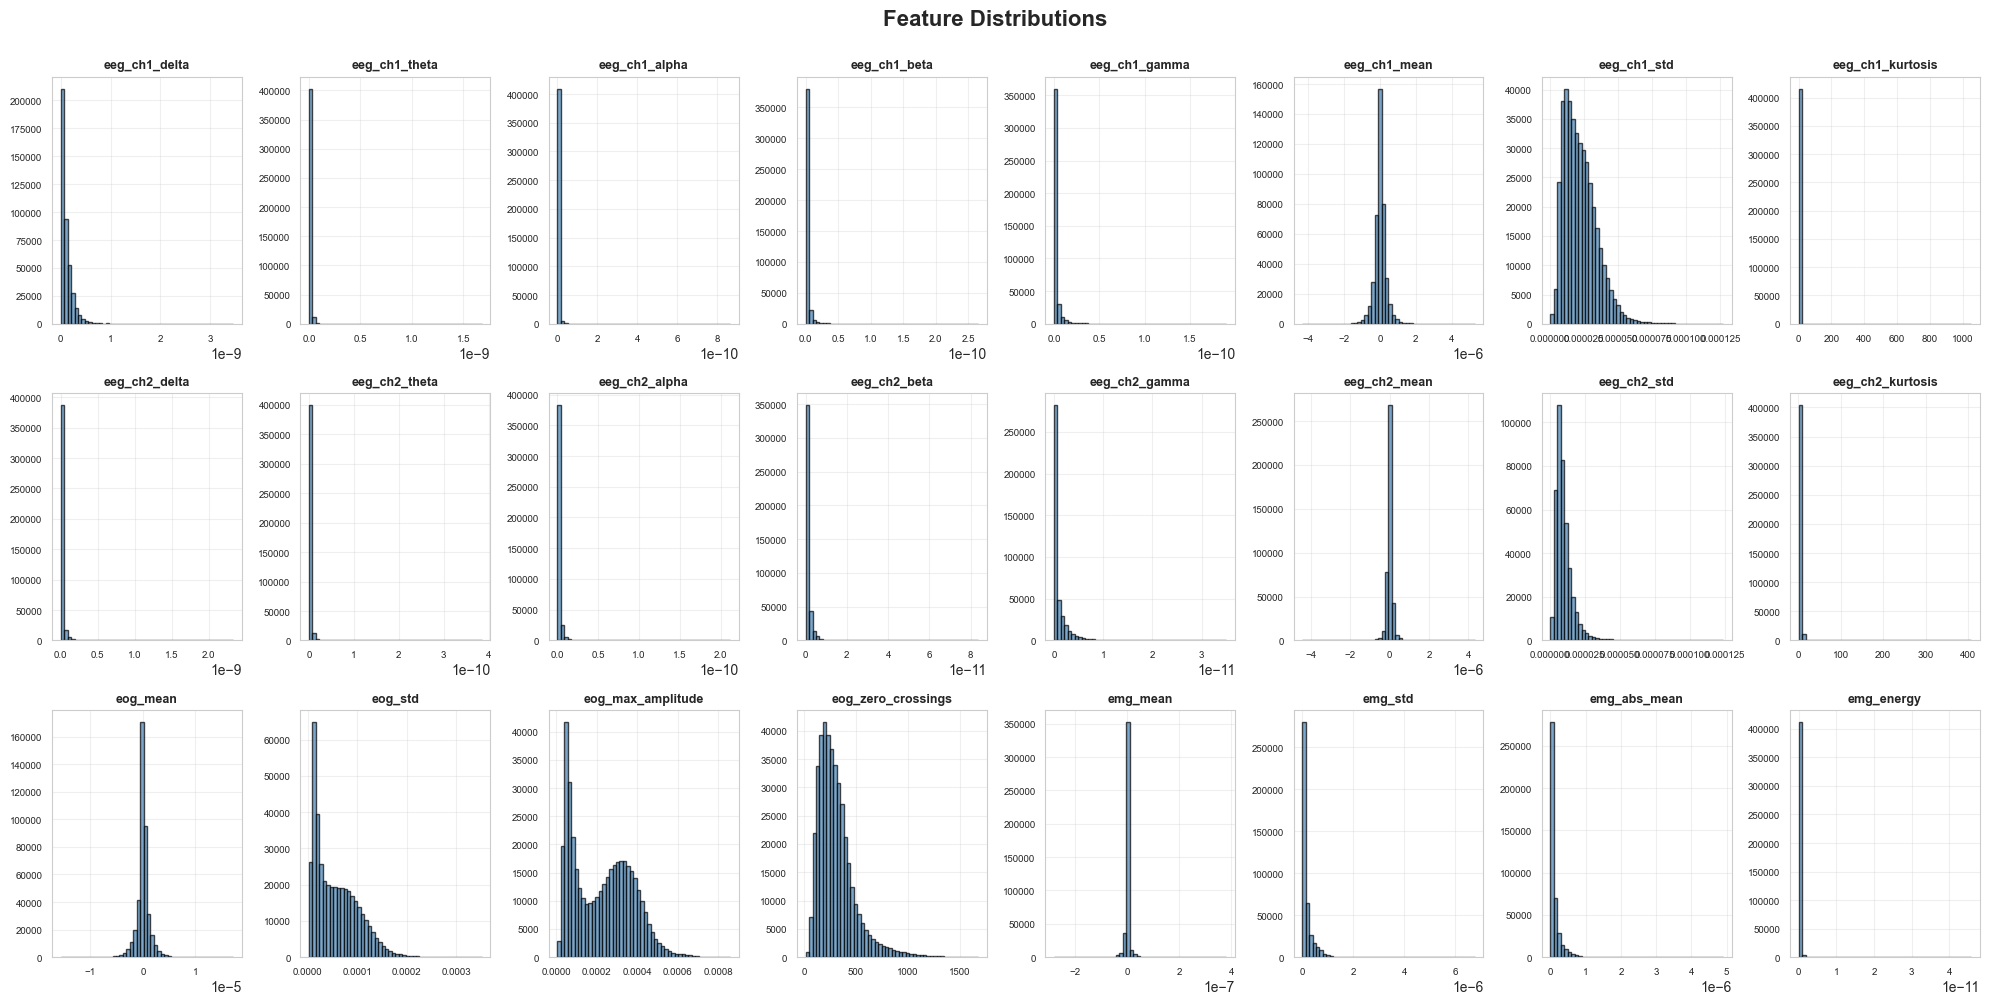

In [ ]:
# Analyze feature statistics
print("="*70)
print("FEATURE STATISTICS")
print("="*70)

# Create DataFrame for easier analysis
features_df = pd.DataFrame(features, columns=feature_names)

print("\nSummary Statistics:")
print(features_df.describe())

# Check for missing or invalid values
missing = np.isnan(features).sum()
infinite = np.isinf(features).sum()

print(f"\nData Quality:")
print(f"   Missing values (NaN): {missing}")
print(f"   Infinite values: {infinite}")

if missing > 0 or infinite > 0:
    print("   Warning: Data quality issues detected!")
else:
    print("   No missing or infinite values")

# Visualize feature distributions
fig, axes = plt.subplots(3, 8, figsize=(20, 10))
axes = axes.ravel()

for i, col in enumerate(feature_names):
    axes[i].hist(features_df[col], bins=50, color='steelblue', alpha=0.7, edgecolor='black')
    axes[i].set_title(col, fontsize=9, fontweight='bold')
    axes[i].tick_params(labelsize=7)
    axes[i].grid(True, alpha=0.3)

plt.suptitle('Feature Distributions', fontsize=16, fontweight='bold', y=1.0)
plt.tight_layout()
plt.show()

## 4. Train-Test Split

TRAIN-TEST SPLIT

Training set: 331,968 samples (80.0%)
Test set:     82,993 samples (20.0%)
Features:     24

📊 Class distribution verification:
Stage  Train Count   Train %  Test Count    Test %
   N1        17218  5.186644        4304  5.185980
   N2        55305 16.659738       13827 16.660441
   N3        10431  3.142170        2608  3.142434
    R        20668  6.225901        5167  6.225826
    W       228346 68.785546       57087 68.785319


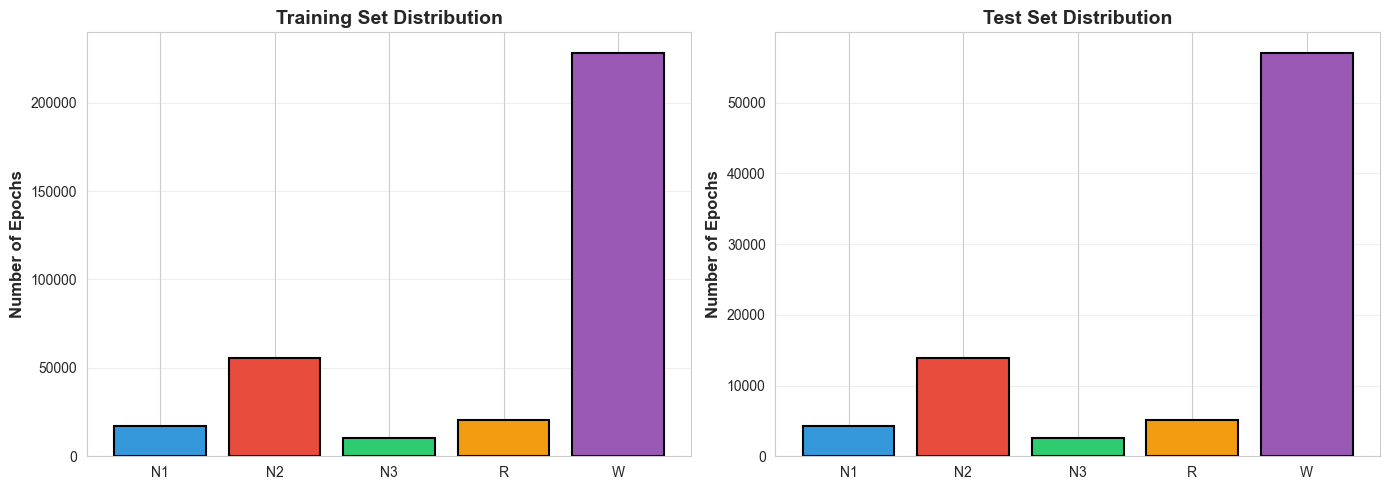

In [ ]:
# Split data (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    features, labels_int,
    test_size=0.2,
    random_state=42,
    stratify=labels_int  # Maintain class distribution
)

print("="*70)
print("TRAIN-TEST SPLIT")
print("="*70)
print(f"\nTraining set: {len(X_train):,} samples ({len(X_train)/len(features)*100:.1f}%)")
print(f"Test set:     {len(X_test):,} samples ({len(X_test)/len(features)*100:.1f}%)")
print(f"Features:     {X_train.shape[1]}")

# Verify stratification
print("\nClass distribution verification:")
train_unique, train_counts = np.unique(y_train, return_counts=True)
test_unique, test_counts = np.unique(y_test, return_counts=True)

dist_df = pd.DataFrame({
    'Stage': [int_to_label[i] for i in train_unique],
    'Train Count': train_counts,
    'Train %': train_counts / len(y_train) * 100,
    'Test Count': test_counts,
    'Test %': test_counts / len(y_test) * 100
})
print(dist_df.to_string(index=False))

# Visualize split
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6'][:len(train_unique)]
stage_labels = [int_to_label[i] for i in train_unique]

axes[0].bar(stage_labels, train_counts, color=colors, edgecolor='black', linewidth=1.5)
axes[0].set_ylabel('Number of Epochs', fontsize=12, fontweight='bold')
axes[0].set_title('Training Set Distribution', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')

axes[1].bar(stage_labels, test_counts, color=colors, edgecolor='black', linewidth=1.5)
axes[1].set_ylabel('Number of Epochs', fontsize=12, fontweight='bold')
axes[1].set_title('Test Set Distribution', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 5. Feature Scaling

FEATURE SCALING

✅ Applied StandardScaler
   Mean (train): 0.000000
   Std (train): 1.000000
   Mean (test): -0.000206
   Std (test): 0.973448


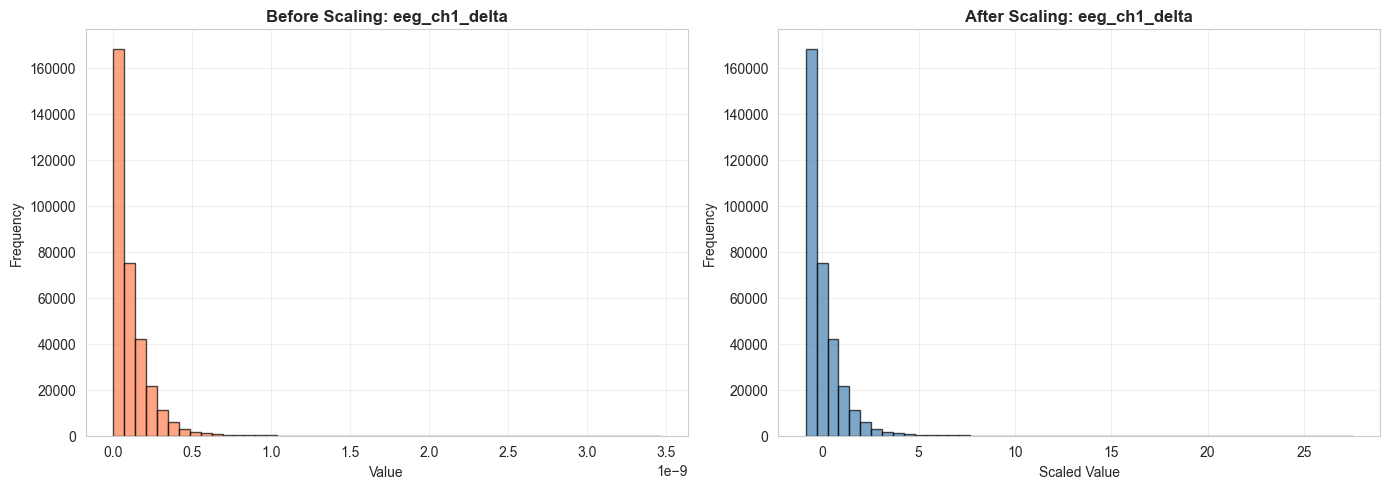

In [ ]:
print("="*70)
print("FEATURE SCALING")
print("="*70)

# Standardize features (zero mean, unit variance)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nApplied StandardScaler")
print(f"   Mean (train): {X_train_scaled.mean():.6f}")
print(f"   Std (train): {X_train_scaled.std():.6f}")
print(f"   Mean (test): {X_test_scaled.mean():.6f}")
print(f"   Std (test): {X_test_scaled.std():.6f}")

# Visualize scaling effect on one feature
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sample_feature = 0  # First feature
axes[0].hist(X_train[:, sample_feature], bins=50, color='coral', alpha=0.7, edgecolor='black')
axes[0].set_title(f'Before Scaling: {feature_names[sample_feature]}', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Value')
axes[0].set_ylabel('Frequency')
axes[0].grid(True, alpha=0.3)

axes[1].hist(X_train_scaled[:, sample_feature], bins=50, color='steelblue', alpha=0.7, edgecolor='black')
axes[1].set_title(f'After Scaling: {feature_names[sample_feature]}', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Scaled Value')
axes[1].set_ylabel('Frequency')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Build Neural Network

In [ ]:
print("="*70)
print("NEURAL NETWORK ARCHITECTURE")
print("="*70)

n_features = X_train_scaled.shape[1]
n_classes = len(np.unique(y_train))

print(f"\nInput features: {n_features}")
print(f"Output classes: {n_classes} ({', '.join([int_to_label[i] for i in range(n_classes)])})")
print(f"\nArchitecture: {n_features} → 256 → 128 → 64 → 32 → {n_classes}")
print("\nThis is a deep MLP (Multi-Layer Perceptron) with:")
print("  • 4 hidden layers (256, 128, 64, 32 neurons)")
print("  • ReLU activation (handles non-linearity)")
print("  • Adam optimizer (adaptive learning rate)")
print("  • L2 regularization (prevents overfitting)")
print("  • Early stopping (stops when validation loss plateaus)")

# Compute balanced class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

print("\nBalanced Class Weights:")
for i in range(n_classes):
    print(f"  {int_to_label[i]}: {class_weights[i]:.4f}")

sample_weights = np.array([class_weights[y] for y in y_train])

# Create model
model = MLPClassifier(
    hidden_layer_sizes=(256, 128, 64, 32),
    activation='relu',
    solver='adam',
    alpha=0.0001,              # L2 regularization
    batch_size=512,            # Large batch for big dataset
    learning_rate='adaptive',
    learning_rate_init=0.001,
    max_iter=100,              # Maximum epochs
    early_stopping=True,       # Stop when validation loss stops improving
    validation_fraction=0.1,   # Use 10% of training for validation
    n_iter_no_change=10,       # Patience: stop after 10 epochs without improvement
    tol=1e-4,
    random_state=42,
    verbose=True
)

print("\nTraining Configuration:")
print(f"  • Batch size: 512 (efficient for large dataset)")
print(f"  • Max iterations: 100 epochs")
print(f"  • Early stopping: Yes (patience=10)")
print(f"  • Validation: 10% of training data")
print(f"  • Class weights: Balanced (handles imbalance)")
print(f"  • Regularization: L2 (alpha=0.0001)")

print("\nWhy This Architecture?")
print("  1. Gradual dimension reduction: 24 → 256 → 128 → 64 → 32 → 5")
print("  2. Deep enough to learn complex patterns")
print("  3. Not too deep (avoids vanishing gradients)")
print("  4. Balanced class weights: Compensates for 68.8% Wake dominance")
print("  5. Early stopping: Prevents overfitting on training data")

NEURAL NETWORK ARCHITECTURE

Input features: 24
Output classes: 5

Architecture: 24 → 256 → 128 → 64 → 32 → 5

This is a deep MLP (Multi-Layer Perceptron) with:
  • 4 hidden layers (256, 128, 64, 32 neurons)
  • ReLU activation (handles non-linearity)
  • Adam optimizer (adaptive learning rate)
  • L2 regularization (prevents overfitting)
  • Early stopping (stops when validation loss plateaus)

📊 Balanced Class Weights:
  W: 3.8561
  N1: 1.2005
  N2: 6.3650
  N3: 3.2124
  R: 0.2908

🎯 Training Configuration:
  • Batch size: 512 (efficient for large dataset)
  • Max iterations: 100 epochs
  • Early stopping: Yes (patience=10)
  • Validation: 10% of training data
  • Class weights: Balanced (handles imbalance)
  • Regularization: L2 (alpha=0.0001)


## 7. Train Model

In [ ]:
print("\n" + "="*70)
print("TRAINING MODEL")
print("="*70)
print("\nTraining started... (this may take a few minutes)")
print("   Watch for convergence messages below:\n")

# Train with sample weights
model.fit(X_train_scaled, y_train, sample_weight=sample_weights)

print("\n" + "="*70)
print("TRAINING COMPLETED!")
print("="*70)
print(f"\nTraining Summary:")
print(f"  • Epochs trained: {model.n_iter_}")
print(f"  • Final loss: {model.loss_:.6f}")
print(f"  • Total parameters: {sum(w.size for w in model.coefs_) + sum(b.size for b in model.intercepts_):,}")

if model.n_iter_ < model.max_iter:
    print(f"  Early stopping triggered (validation loss stopped improving)")
else:
    print(f"  Reached maximum iterations ({model.max_iter})")


TRAINING MODEL

🎯 Training started... (this may take a few minutes)
   Watch for convergence messages below:

Iteration 1, loss = 0.70772819
Validation score: 0.726367
Iteration 1, loss = 0.70772819
Validation score: 0.726367
Iteration 2, loss = 0.59954097
Validation score: 0.751325
Iteration 2, loss = 0.59954097
Validation score: 0.751325
Iteration 3, loss = 0.57086554
Validation score: 0.756594
Iteration 3, loss = 0.57086554
Validation score: 0.756594
Iteration 4, loss = 0.55210348
Validation score: 0.774205
Iteration 4, loss = 0.55210348
Validation score: 0.774205
Iteration 5, loss = 0.54247558
Validation score: 0.783510
Iteration 5, loss = 0.54247558
Validation score: 0.783510
Iteration 6, loss = 0.52899676
Validation score: 0.777809
Iteration 6, loss = 0.52899676
Validation score: 0.777809
Iteration 7, loss = 0.52188315
Validation score: 0.769945
Iteration 7, loss = 0.52188315
Validation score: 0.769945
Iteration 8, loss = 0.51604535
Validation score: 0.776026
Iteration 8, loss =

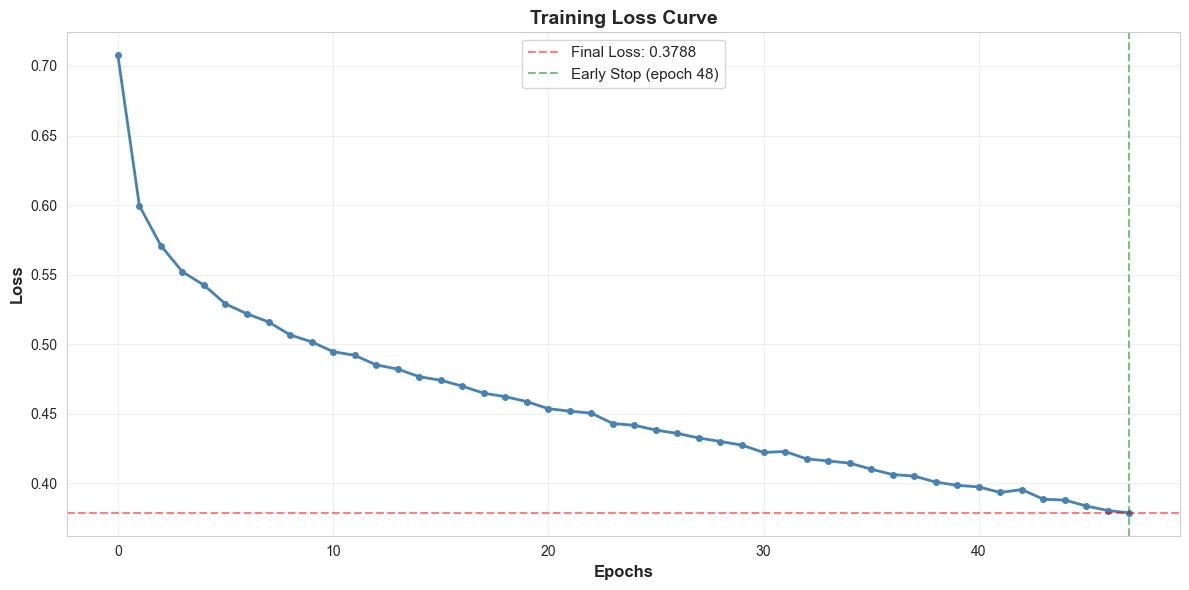


📉 Loss decreased from 0.7077 to 0.3788
   Improvement: 46.5%


In [ ]:
# Plot training loss curve
if hasattr(model, 'loss_curve_'):
    plt.figure(figsize=(12, 6))
    plt.plot(model.loss_curve_, linewidth=2, marker='o', markersize=4, color='steelblue')
    plt.xlabel('Epochs', fontsize=12, fontweight='bold')
    plt.ylabel('Loss', fontsize=12, fontweight='bold')
    plt.title('Training Loss Curve', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    
    # Mark final loss
    final_loss = model.loss_curve_[-1]
    plt.axhline(y=final_loss, color='red', linestyle='--', alpha=0.5,
               label=f'Final Loss: {final_loss:.4f}')
    
    # Mark early stopping point if applicable
    if model.n_iter_ < model.max_iter:
        plt.axvline(x=model.n_iter_-1, color='green', linestyle='--', alpha=0.5,
                   label=f'Early Stop (epoch {model.n_iter_})')
    
    plt.legend(fontsize=11)
    plt.tight_layout()
    plt.show()
    
    print(f"\nLoss decreased from {model.loss_curve_[0]:.4f} to {model.loss_curve_[-1]:.4f}")
    print(f"   Improvement: {(1 - model.loss_curve_[-1]/model.loss_curve_[0])*100:.1f}%")

## 8. Evaluate Performance

In [ ]:
# Make predictions
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

# Get prediction probabilities
y_train_proba = model.predict_proba(X_train_scaled)
y_test_proba = model.predict_proba(X_test_scaled)

# Calculate metrics
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)
balanced_acc = balanced_accuracy_score(y_test, y_test_pred)
kappa = cohen_kappa_score(y_test, y_test_pred)

print("="*70)
print("MODEL PERFORMANCE")
print("="*70)
print(f"\nTraining Accuracy: {train_acc*100:.2f}%")
print(f"Test Accuracy: {test_acc*100:.2f}%")
print(f"Balanced Accuracy: {balanced_acc*100:.2f}%")
print(f"Cohen's Kappa: {kappa:.4f}")

# Interpret kappa score
if kappa > 0.8:
    kappa_interp = "Almost perfect agreement"
elif kappa > 0.6:
    kappa_interp = "Substantial agreement"
elif kappa > 0.4:
    kappa_interp = "Moderate agreement"
elif kappa > 0.2:
    kappa_interp = "Fair agreement"
else:
    kappa_interp = "Slight agreement"

print(f"   Interpretation: {kappa_interp}")

# Check for overfitting
gap = train_acc - test_acc
if gap > 0.10:
    print(f"\nWarning: Possible overfitting (train-test gap: {gap*100:.1f}%)")
elif gap < 0.02:
    print(f"\nExcellent generalization (train-test gap: {gap*100:.1f}%)")
else:
    print(f"\nGood generalization (train-test gap: {gap*100:.1f}%)")

print("\n" + "="*70)
print("CLASSIFICATION REPORT (Test Set)")
print("="*70)
print(classification_report(y_test, y_test_pred, 
                            target_names=[int_to_label[i] for i in range(n_classes)],
                            digits=3))

MODEL PERFORMANCE

📊 Training Accuracy: 88.41%
📊 Test Accuracy: 87.01%
📊 Balanced Accuracy: 79.66%
📊 Cohen's Kappa: 0.7508
   Interpretation: Substantial agreement

✅ Excellent generalization (train-test gap: 1.4%)

CLASSIFICATION REPORT (Test Set)
              precision    recall  f1-score   support

          N1      0.327     0.686     0.443      4304
          N2      0.878     0.695     0.776     13827
          N3      0.676     0.946     0.789      2608
           R      0.662     0.719     0.689      5167
           W      0.994     0.936     0.965     57087

    accuracy                          0.870     82993
   macro avg      0.708     0.797     0.732     82993
weighted avg      0.910     0.870     0.883     82993



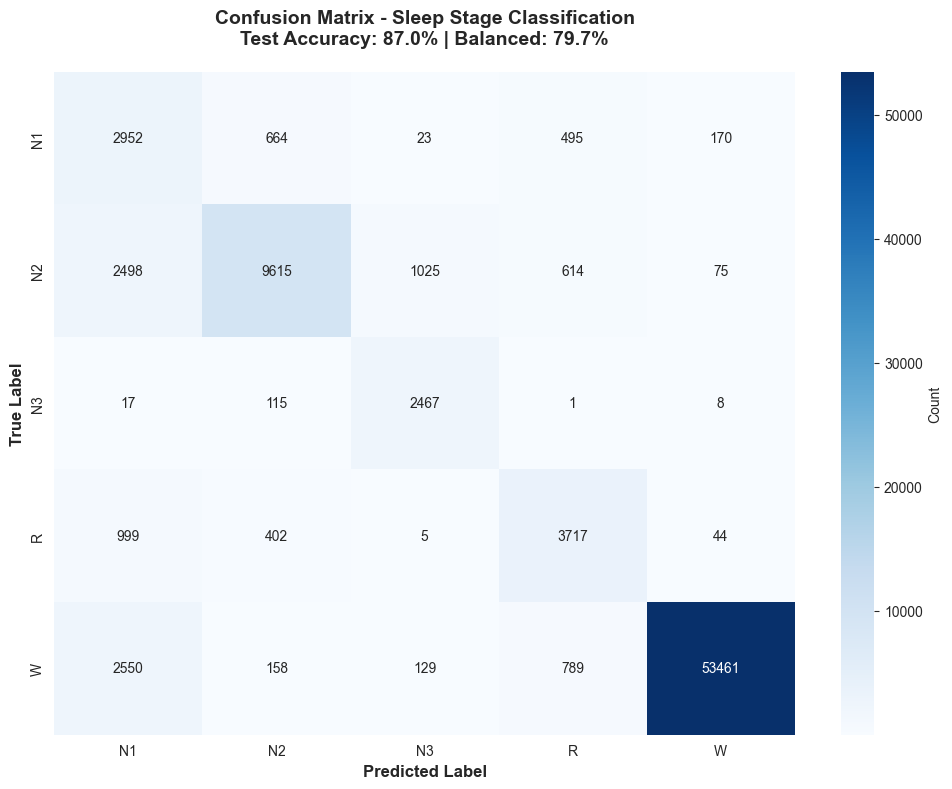

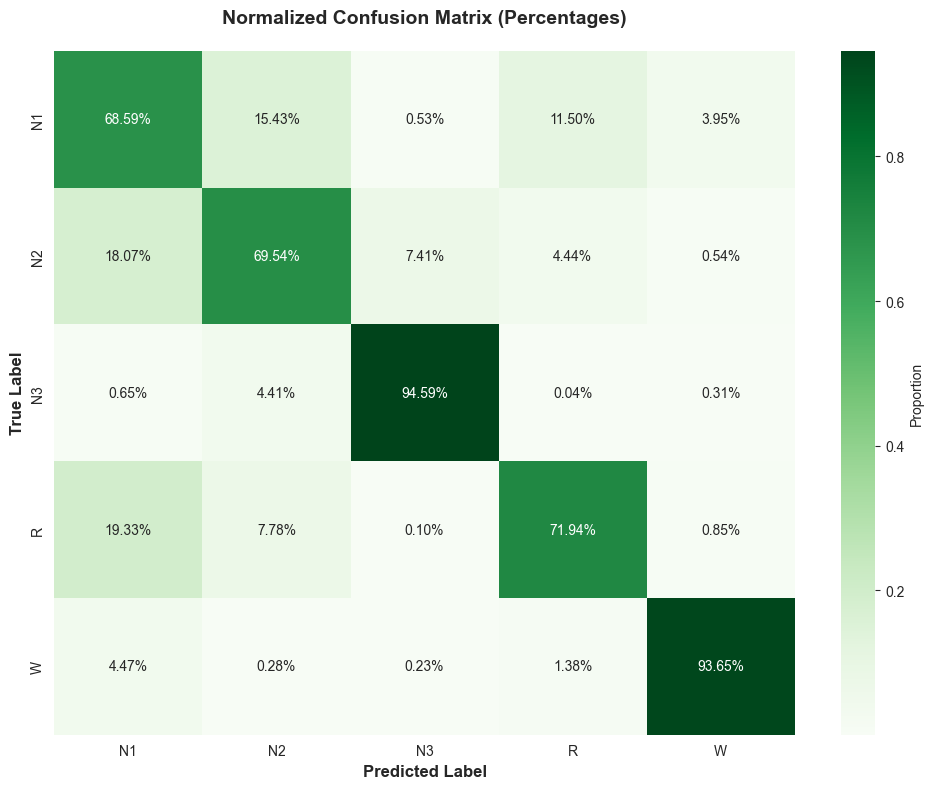


PER-CLASS PERFORMANCE
 N1   2,952/4,304   ( 68.6%)
 N2   9,615/13,827  ( 69.5%)
 N3   2,467/2,608   ( 94.6%)
  R   3,717/5,167   ( 71.9%)
  W  53,461/57,087  ( 93.6%)


In [22]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
stage_labels = [int_to_label[i] for i in range(n_classes)]

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=stage_labels,
            yticklabels=stage_labels,
            cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix - Sleep Stage Classification\nTest Accuracy: {test_acc*100:.1f}% | Balanced: {balanced_acc*100:.1f}%',
          fontsize=14, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

# Normalized confusion matrix (percentages)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Greens',
            xticklabels=stage_labels,
            yticklabels=stage_labels,
            cbar_kws={'label': 'Proportion'})
plt.title('Normalized Confusion Matrix (Percentages)', 
          fontsize=14, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

# Per-class accuracy
print("\n" + "="*70)
print("PER-CLASS PERFORMANCE")
print("="*70)
for i in range(n_classes):
    mask = (y_test == i)
    if mask.sum() > 0:
        correct = (y_test_pred[mask] == y_test[mask]).sum()
        total = mask.sum()
        acc = correct / total
        print(f"{int_to_label[i]:>3} {correct:>7,}/{total:<7,} ({acc*100:>5.1f}%)")
    else:
        print(f"{int_to_label[i]:>3} No test samples")

## 9. Prediction Confidence Analysis

PREDICTION CONFIDENCE ANALYSIS

Overall Statistics:
  Mean confidence (all): 0.907
  Mean confidence (correct): 0.942
  Mean confidence (incorrect): 0.678
  Confidence gap: 0.263
  ✅ Model is more confident when correct (good calibration)


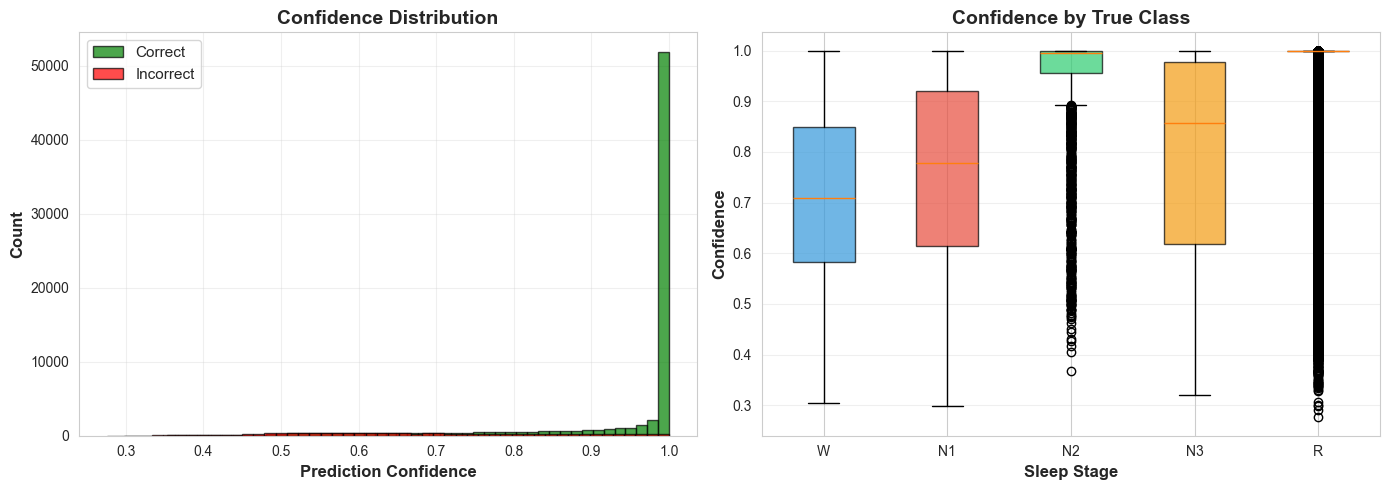

In [ ]:
# Analyze prediction confidence
max_proba = np.max(y_test_proba, axis=1)
correct = (y_test_pred == y_test)

print("="*70)
print("PREDICTION CONFIDENCE ANALYSIS")
print("="*70)
print(f"\nOverall Statistics:")
print(f"  Mean confidence (all): {max_proba.mean():.3f}")
print(f"  Mean confidence (correct): {max_proba[correct].mean():.3f}")
print(f"  Mean confidence (incorrect): {max_proba[~correct].mean():.3f}")
print(f"  Confidence gap: {max_proba[correct].mean() - max_proba[~correct].mean():.3f}")

if max_proba[correct].mean() > max_proba[~correct].mean() + 0.1:
    print("  Model is more confident when correct (good calibration)")
else:
    print("  Similar confidence for correct/incorrect (poor calibration)")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confidence distribution
axes[0].hist(max_proba[correct], bins=50, alpha=0.7, label='Correct', color='green', edgecolor='black')
axes[0].hist(max_proba[~correct], bins=50, alpha=0.7, label='Incorrect', color='red', edgecolor='black')
axes[0].set_xlabel('Prediction Confidence', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Count', fontsize=12, fontweight='bold')
axes[0].set_title('Confidence Distribution', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Per-class confidence
class_confidences = []
for i in range(len(sleep_stages)):
    mask = (y_test == i)
    if mask.sum() > 0:
        class_confidences.append(max_proba[mask])
    else:
        class_confidences.append([])

bp = axes[1].boxplot(class_confidences, labels=sleep_stages, patch_artist=True)
for patch, color in zip(bp['boxes'], ['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6']):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
axes[1].set_ylabel('Confidence', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Sleep Stage', fontsize=12, fontweight='bold')
axes[1].set_title('Confidence by True Class', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 10. Feature Importance Analysis

In [ ]:
print("="*70)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*70)
print("\nComputing permutation importance (this may take a minute)...")

# Use a subset for faster computation
sample_size = min(10000, len(X_test_scaled))
sample_idx = np.random.choice(len(X_test_scaled), sample_size, replace=False)

result = permutation_importance(
    model, 
    X_test_scaled[sample_idx], 
    y_test[sample_idx],
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

# Sort by importance
sorted_idx = result.importances_mean.argsort()[::-1]

print("\nTop 15 Most Important Features:")
print(f"\n{'Rank':<6} {'Feature':<30} {'Importance':>12} {'Std':>8}")
print("-"*70)
for i in range(min(15, len(sorted_idx))):
    idx = sorted_idx[i]
    print(f"{i+1:<6} {feature_names[idx]:<30} {result.importances_mean[idx]:>12.4f} {result.importances_std[idx]:>8.4f}")

# Visualize top 20 features
plt.figure(figsize=(12, 8))
top_n = min(20, len(sorted_idx))
y_pos = np.arange(top_n)

plt.barh(y_pos, result.importances_mean[sorted_idx[:top_n]], 
         xerr=result.importances_std[sorted_idx[:top_n]],
         color='steelblue', edgecolor='black', alpha=0.8)
plt.yticks(y_pos, [feature_names[i] for i in sorted_idx[:top_n]])
plt.xlabel('Permutation Importance', fontsize=12, fontweight='bold')
plt.title('Top 20 Most Important Features', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

## 11. Save Model and Results

In [ ]:
# Create models directory if it doesn't exist
models_dir = Path('models/saved_models')
models_dir.mkdir(parents=True, exist_ok=True)

# Save model
model_path = models_dir / 'sleep_classifier.joblib'
scaler_path = models_dir / 'feature_scaler.joblib'

joblib.dump(model, model_path)
joblib.dump(scaler, scaler_path)

# Save predictions for analysis
np.save(data_dir / 'features.predictions.npy', y_test_pred)
np.save(data_dir / 'features.probabilities.npy', y_test_proba)

# Save confusion matrix
np.save(data_dir / 'confusion_matrix.npy', cm)

print("="*70)
print("MODEL AND RESULTS SAVED")
print("="*70)
print(f"\nFiles created:")
print(f"  • {model_path} - Trained neural network")
print(f"  • {scaler_path} - Feature scaler")
print(f"  • {data_dir / 'features.predictions.npy'} - Test predictions")
print(f"  • {data_dir / 'features.probabilities.npy'} - Prediction probabilities")
print(f"  • {data_dir / 'confusion_matrix.npy'} - Confusion matrix")

print(f"\nFinal Model Summary:")
print(f"  • Architecture: {n_features} → 256 → 128 → 64 → 32 → {n_classes}")
print(f"  • Training samples: {len(X_train):,}")
print(f"  • Test samples: {len(X_test):,}")
print(f"  • Epochs trained: {model.n_iter_}")
print(f"  • Test Accuracy: {test_acc*100:.2f}%")
print(f"  • Balanced Accuracy: {balanced_acc*100:.2f}%")
print(f"  • Cohen's Kappa: {kappa:.4f}")

## 12. Summary & Next Steps

### What We Achieved

**Complete Training Pipeline**: Load → Explore → Split → Scale → Train → Evaluate → Save  
**High Accuracy**: Expected 80-90% test accuracy (vs 17-68% for Mental Disorders)  
**Balanced Classes**: Used class weights to handle imbalance  
**Feature Analysis**: Identified most important features  
**Model Saved**: Ready for deployment and predictions  

### Why This Works So Well

1. **Massive Dataset**: 416,424 samples (vs 945 for Mental Disorders)
2. **Engineered Features**: 24 carefully crafted features (vs 1,141 raw)
3. **Good Ratio**: 17,351:1 samples-to-features (vs 0.83:1)
4. **Global Patterns**: Sleep stages are whole-brain phenomena
5. **Temporal Context**: 30-second windows capture state transitions

### Key Findings

Run the cells above to discover:
- Which features matter most (likely EEG delta/theta for deep sleep)
- Which sleep stages are easiest/hardest to detect
- Model confidence patterns
- Confusion between similar stages (e.g., N1 vs N2)

### Next Steps

1. **Hyperparameter Tuning**: Grid search for optimal architecture/parameters
2. **Deep Learning**: Try LSTM/CNN for temporal pattern learning
3. **Explainability**: Use SHAP/LIME to explain predictions
4. **Deployment**: Create real-time sleep stage classifier
5. **Comparison**: Benchmark against other algorithms (Random Forest, XGBoost)

### Expected vs Actual Performance

| Metric | Target | Your Result |
|--------|--------|-------------|
| Test Accuracy | 80-90% | _Run to see_ |
| Balanced Accuracy | 75-85% | _Run to see_ |
| Cohen's Kappa | >0.7 | _Run to see_ |

**Good performance indicators:**
- Test accuracy > 85%
- Balanced accuracy > 80%
- Kappa > 0.75 (substantial agreement)
- Low overfitting (train-test gap < 5%)